Always Run after 1.30 AM IST.

In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch import arch_model
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

In [2]:
# Getting the current date
from datetime import date
today = date.today()
today

datetime.date(2022, 6, 1)

In [3]:
# Yesterday date
from datetime import timedelta
yesterday = today - timedelta(days = 1)
yesterday

datetime.date(2022, 5, 31)

In [4]:
raw_data = yfinance.download (tickers = "^NSEI ^INDIAVIX ^FTSE ^N225 ^NYA", start = "2020-03-23", end = today,
                              interval = "1d", group_by = 'ticker', auto_adjust = True, treads = True)

[*********************100%***********************]  5 of 5 completed


In [5]:
df_comp = raw_data.copy()

In [6]:
df_comp['nifty'] = df_comp['^NSEI'].Close[:]
df_comp['ivix'] = df_comp['^INDIAVIX'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]
df_comp['nyse'] = df_comp['^NYA'].Close[:]

In [7]:
df_comp = df_comp.iloc[1:]
del df_comp['^NSEI']
del df_comp['^INDIAVIX']
del df_comp['^FTSE']
del df_comp['^N225']
del df_comp['^NYA']
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

In [8]:
df_comp.tail()

,nifty,ivix,ftse,nikkei,nyse
,,,,,
Date,,,,,
2022-05-25,16025.799805,NaN,7522.799805,26677.800781,15412.190430
2022-05-26,16170.150391,NaN,7564.899902,26604.839844,15664.000000
2022-05-27,16352.450195,NaN,7585.500000,26781.679688,15942.620117
2022-05-30,16661.400391,NaN,7600.100098,27369.429688,15942.620117
2022-05-31,16584.550781,20.477501,7607.660156,27279.800781,15827.048828


In [9]:
df_comp['ivix'] = df_comp['ivix'].fillna(0)

In [10]:
df_comp['ret_nifty'] = df_comp.nifty.pct_change(1).mul(100)
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1).mul(100)
df_comp['ret_nikkei'] = df_comp.nikkei.pct_change(1).mul(100)
df_comp['ret_nyse'] = df_comp.nyse.pct_change(1).mul(100)

In [11]:
df_comp['norm_ret_nifty'] = df_comp.nifty.div(df_comp.ret_nifty[1])*100
df_comp['norm_ret_ftse'] = df_comp.ret_ftse.div(df_comp.ret_ftse[1])*100
df_comp['norm_ret_nikkei'] = df_comp.ret_nikkei.div(df_comp.ret_nikkei[1])*100
df_comp['norm_ret_nyse'] = df_comp.ret_nyse.div(df_comp.ret_nyse[1])*100

In [12]:
df_comp.head()

,nifty,ivix,ftse,nikkei,nyse,ret_nifty,ret_ftse,ret_nikkei,ret_nyse,norm_ret_nifty,norm_ret_ftse,norm_ret_nikkei,norm_ret_nyse
,,,,,,,,,,,,,
Date,,,,,,,,,,,,,
2020-03-24,7801.049805,0.0,5446.000000,18092.349609,9658.320312,NaN,NaN,NaN,NaN,117756.193991,NaN,NaN,NaN
2020-03-25,8317.849609,0.0,5688.200195,19546.630859,9961.379883,6.624747,4.447304,8.038101,3.137808,125557.243796,100.000000,100.000000,100.000000
2020-03-26,8641.450195,0.0,5815.700195,18664.599609,10536.280273,3.890436,2.241482,-4.512446,5.771293,130441.967561,50.400920,-56.138219,183.927515
2020-03-27,8660.250000,0.0,5510.299805,19389.429688,10187.209961,0.217554,-5.251309,3.883448,-3.313032,130725.749039,-118.078472,48.313010,-105.584265
2020-03-30,8281.099609,0.0,5563.700195,19084.970703,10434.740234,-4.378054,0.969101,-1.570232,2.429814,125002.505621,21.790759,-19.534861,77.436669


In [13]:
df_comp.tail()

,nifty,ivix,ftse,nikkei,nyse,ret_nifty,ret_ftse,ret_nikkei,ret_nyse,norm_ret_nifty,norm_ret_ftse,norm_ret_nikkei,norm_ret_nyse
,,,,,,,,,,,,,
Date,,,,,,,,,,,,,
2022-05-25,16025.799805,0.000000,7522.799805,26677.800781,15412.190430,-0.616122,0.513066,-0.262971,0.796648,241908.106974,11.536559,-3.271556,25.388686
2022-05-26,16170.150391,0.000000,7564.899902,26604.839844,15664.000000,0.900739,0.559633,-0.273489,1.633834,244087.066989,12.583653,-3.402412,52.069267
2022-05-27,16352.450195,0.000000,7585.500000,26781.679688,15942.620117,1.127385,0.272312,0.664691,1.778729,246838.867285,6.123070,8.269248,56.686990
2022-05-30,16661.400391,0.000000,7600.100098,27369.429688,15942.620117,1.889321,0.192474,2.194597,0.000000,251502.444630,4.327875,27.302436,0.000000
2022-05-31,16584.550781,20.477501,7607.660156,27279.800781,15827.048828,-0.461243,0.099473,-0.327478,-0.724920,250342.406207,2.236706,-4.074074,-23.102760


In [14]:
size = int(len(df_comp)*0.96)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [15]:
# def predict_dates(num_prediction):
#     last_date = df_test['Date'].values[-1]
#     prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
#     return prediction_dates

In [16]:
# num_prediction = 7

In [17]:
# forecast_dates = predict_dates(num_prediction)

In [18]:
col = df.columns

In [19]:
df_test.head()

,nifty,ivix,ftse,nikkei,nyse,ret_nifty,ret_ftse,ret_nikkei,ret_nyse,norm_ret_nifty,norm_ret_ftse,norm_ret_nikkei,norm_ret_nyse
,,,,,,,,,,,,,
Date,,,,,,,,,,,,,
2022-04-29,17102.550781,0.0,7544.600098,26847.900391,15615.250000,-0.826324,0.471420,0.000000,-2.603618,258161.572860,10.600138,0.000000,-82.975680
2022-05-02,17069.099609,0.0,7544.600098,26818.529297,15609.280273,-0.195592,0.000000,-0.109398,-0.038230,257656.630220,0.000000,-1.360994,-1.218370
2022-05-03,17069.099609,0.0,7561.299805,26818.529297,15729.530273,0.000000,0.221346,0.000000,0.770375,257656.630220,4.977093,0.000000,24.551374
2022-05-04,16677.599609,0.0,7493.500000,26818.529297,16119.610352,-2.293618,-0.896669,0.000000,2.479922,251746.970481,-20.162071,0.000000,79.033573
2022-05-05,16682.650391,0.0,7503.299805,26818.529297,15652.610352,0.030285,0.130777,0.000000,-2.897092,251823.211602,2.940599,0.000000,-92.328534


In [20]:
df_test.tail()

,nifty,ivix,ftse,nikkei,nyse,ret_nifty,ret_ftse,ret_nikkei,ret_nyse,norm_ret_nifty,norm_ret_ftse,norm_ret_nikkei,norm_ret_nyse
,,,,,,,,,,,,,
Date,,,,,,,,,,,,,
2022-05-25,16025.799805,0.000000,7522.799805,26677.800781,15412.190430,-0.616122,0.513066,-0.262971,0.796648,241908.106974,11.536559,-3.271556,25.388686
2022-05-26,16170.150391,0.000000,7564.899902,26604.839844,15664.000000,0.900739,0.559633,-0.273489,1.633834,244087.066989,12.583653,-3.402412,52.069267
2022-05-27,16352.450195,0.000000,7585.500000,26781.679688,15942.620117,1.127385,0.272312,0.664691,1.778729,246838.867285,6.123070,8.269248,56.686990
2022-05-30,16661.400391,0.000000,7600.100098,27369.429688,15942.620117,1.889321,0.192474,2.194597,0.000000,251502.444630,4.327875,27.302436,0.000000
2022-05-31,16584.550781,20.477501,7607.660156,27279.800781,15827.048828,-0.461243,0.099473,-0.327478,-0.724920,250342.406207,2.236706,-4.074074,-23.102760


In [30]:
test_date_start = pd.Series(df_test.index.strftime("%Y-%m-%d")).iat[0]
test_date_start

'2022-04-29'

### ARMAX

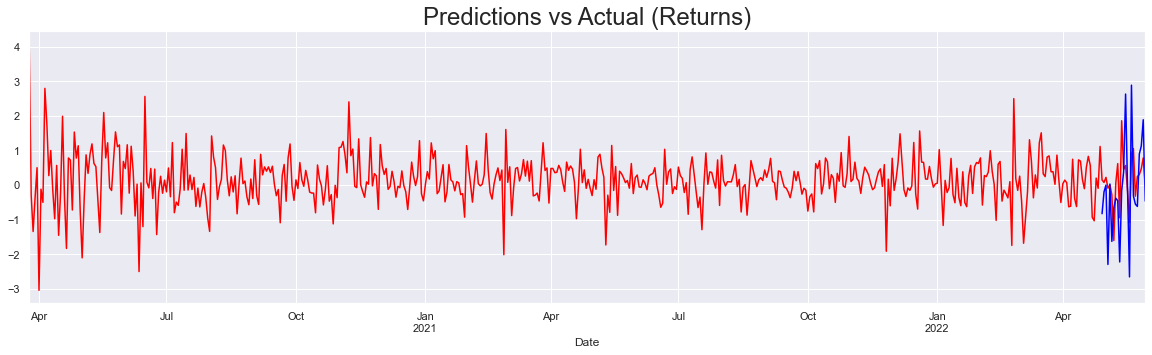

In [21]:
start_date = "2020-03-25"
end_date = yesterday
model_ret_armax = ARIMA(df.ret_nifty[1:], exog = df[["ivix","ret_ftse","ret_nikkei","ret_nyse"]][1:], order = (1,0,1))

results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(start = start_date, end = end_date, 
                                          exog = df_test[["ivix","ret_ftse","ret_nikkei","ret_nyse"]][start_date:end_date]) 

df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_nifty[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

Blue is actual while Red is predictions

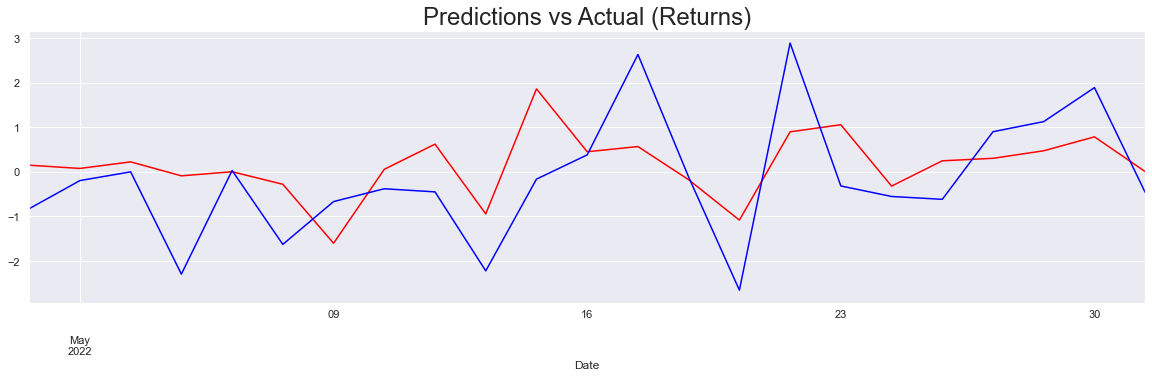

In [31]:
# Lets zoom in a bit

start_date = test_date_start
end_date = yesterday
model_ret_armax = ARIMA(df.ret_nifty[1:], exog = df[["ivix","ret_ftse","ret_nikkei","ret_nyse"]][1:], order = (1,0,1))

results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(start = start_date, end = end_date, 
                                          exog = df_test[["ivix","ret_ftse","ret_nikkei","ret_nyse"]][start_date:end_date]) 

df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_nifty[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

### SARIMAX

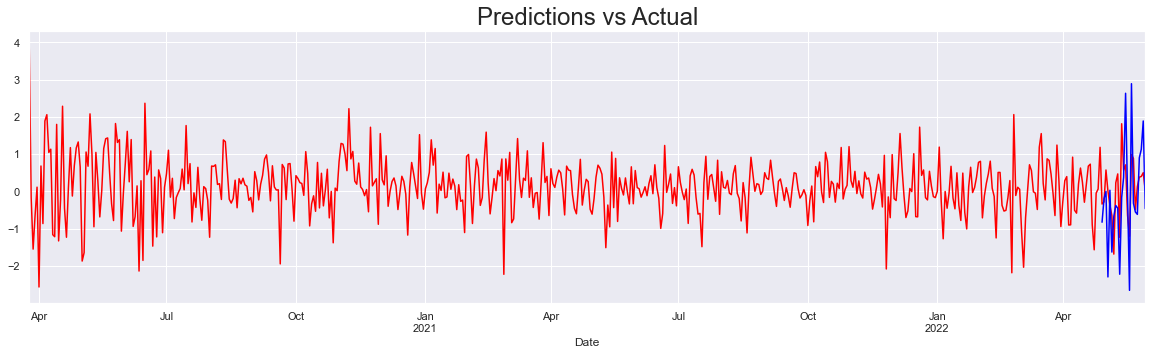

In [23]:
start_date = "2020-03-25"
end_date = yesterday
model_ret_sarimax = SARIMAX(df.ret_nifty[1:], exog = df[["ivix","ret_ftse","ret_nikkei","ret_nyse"]][1:], 
                            order = (3,0,4), seasonal_order = (3,0,2,5))
results_ret_sarimax = model_ret_sarimax.fit()

df_pred_sarimax = results_ret_sarimax.predict(start = start_date, end = end_date, 
                                              exog = df_test[["ivix","ret_ftse","ret_nikkei","ret_nyse"]][start_date:end_date]) 

df_pred_sarimax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_nifty[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

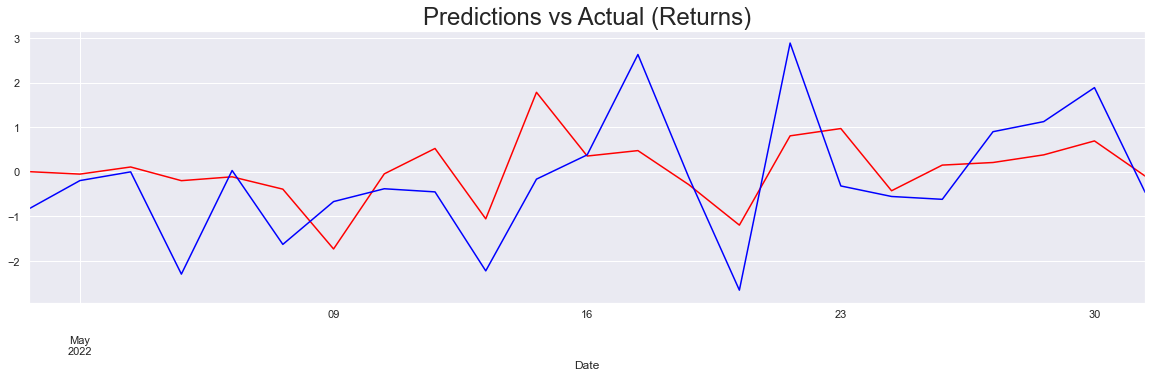

In [32]:
# Lets zoom in a bit

start_date = test_date_start
end_date = yesterday
model_ret_sarimax = SARIMAX(df.ret_nifty[1:], exog = df[["ivix","ret_ftse","ret_nikkei","ret_nyse"]][1:], order = (1,0,1))

results_ret_sarimax = model_ret_sarimax.fit()

df_pred_sarimax = results_ret_sarimax.predict(start = start_date, end = end_date, 
                                          exog = df_test[["ivix","ret_ftse","ret_nikkei","ret_nyse"]][start_date:end_date]) 

df_pred_sarimax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_nifty[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()